<a href="https://colab.research.google.com/github/soline013/Machine-Learning-ML/blob/master/Style-Transfer/Neural_Style_Transfer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [ ]:
from __future__ import print_function
from PIL import Image
from torchvision.utils import save_image

import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Image

In [ ]:
#Height Image Size.
imsize = 512 if torch.cuda.is_available() else 128
print(imsize)

512


In [ ]:
#Width Image Size.
imsize_ = 640 if torch.cuda.is_available() else 160
print(imsize_)

640


In [ ]:
loader = transforms.Compose([transforms.Resize([imsize, imsize_]), #Change image size.
                             transforms.ToTensor()]) #Transform it into a "torch tensor". [0, 255] -> [0, 1].

def image_loader(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0) #Dimension Expansion for Batch.
  return image.to(device, torch.float) #Use GPU.

style_image = image_loader("/content/drive/MyDrive/Colab Notebooks/images/van.jpg")
content_image = image_loader("/content/drive/MyDrive/Colab Notebooks/images/mypic.jpg")

assert style_image.size() == content_image.size(), \
  "Images have same size."

In [ ]:
style_image.size()

torch.Size([1, 3, 512, 640])

In [ ]:
content_image.size()

torch.Size([1, 3, 512, 640])

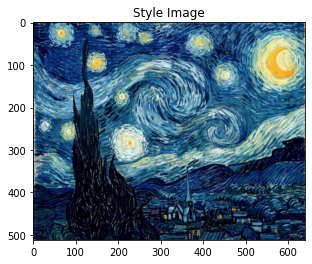

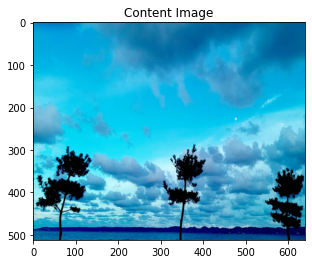

In [ ]:
unloader = transforms.ToPILImage() #Reconvert into PIL image.

#plt.ion() #Update the image each time.

def imshow(tensor, title=None):
  image = tensor.cpu().clone() #Move to CPU for Matplotlib.
  image = image.squeeze(0) #Remove the fake batch dimension.
  image = unloader(image)
  plt.imshow(image)
  if title:
    plt.title(title)
  #plt.pause(0.001) #Pause a bit.

plt.figure()
imshow(style_image, title='Style Image')

plt.figure()
imshow(content_image, title='Content Image')

## Loss Functions

### Content Loss

$$\mathcal{L}_{content}(\vec{p}, \vec{x}, l) = \frac{1}{2} \sum_{i, j} (F^l_{ij} - P^l_{ij})^2$$

In [ ]:
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    self.target = target.detach()
  
  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

### Style Loss

$$G^l_{ij} = \sum_k F^l_{ik} F^l_{jk}$$

In [ ]:
def gram_matrix(input):
  '''
  a = batch size (= 1)
  b = number of feature maps
  c, d = dimensions of a feature map (N = c * d)
  '''
  a, b, c, d = input.size()

  features = input.view(a * b, c * d) #Resize F_XL into \hat{F_XL}.

  '''
  `torch.mm()`
  Matrix Multiplication.
  This function does not broadcast.
  Broadcasting matrix products is `torch.matmul()`
  '''
  G = torch.mm(features, features.t()) #Compute the gram product.

  #Normalize the values of the gram matrix.
  #By Dividing the number of element in each feature maps.
  return G.div(a * b * c * d)

$$E_l = \frac{1}{4N^2_lM^2_l} \sum_{i,j} (G^l_{ij} - A^l_{ij})^2$$

In [ ]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

## Import Model

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
#Normalization Mean & Std.
#`torch.tensor` to `torch.as_tensor`
cnn_normalization_mean = torch.as_tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.as_tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = torch.as_tensor(mean).view(-1, 1, 1)
    self.std = torch.as_tensor(std).view(-1, 1, 1)

  def forward(self, img):
    #Normalize Image.
    return (img - self.mean) / self.std

In [ ]:
content_layers_default = ['conv_5']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def style_model_losses(cnn, normalization_mean, normalization_std,
                       style_image, content_image,
                       content_layers=content_layers_default,
                       style_layers=style_layers_default):
  cnn = copy.deepcopy(cnn)
  normalization = Normalization(normalization_mean, normalization_std).to(device)

  content_losses = []
  style_losses = []

  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    if name in content_layers:
      target = model(content_image).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      target_feature = model(style_image).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  #After Last Style Loss do not use.
  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break

  model = model[:(i + 1)]

  return model, style_losses, content_losses

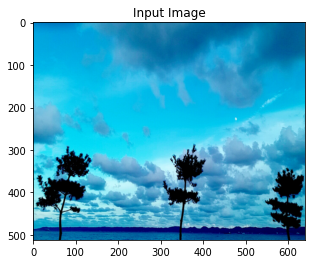

In [ ]:
#First Input Image.
#Content Image.
input_image = content_image.clone()

plt.figure()
imshow(input_image, title='Input Image')

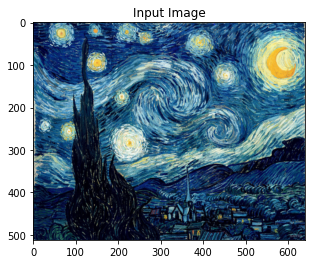

In [ ]:
#Second Input Image.
#Style Image.
input_image_style = style_image.clone()

plt.figure()
imshow(input_image_style, title='Input Image')

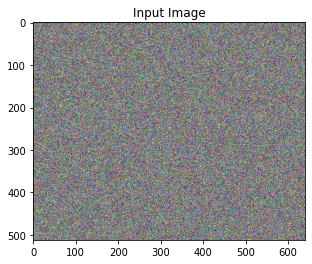

In [ ]:
#Third Input Image.
#Noise Image.
input_image_noise = torch.empty_like(content_image).uniform_(0, 1).to(device)

plt.figure()
imshow(input_image_noise, title='Input Image')

## Gradient Descent

In [ ]:
def input_optimizer(input_image):
  optimizer = optim.LBFGS([input_image.requires_grad_()])
  return optimizer

In [ ]:
def input_optimizer_Adam(input_image):
  optimizer = optim.Adam([input_image.requires_grad_()])
  return optimizer

In [ ]:
def style_transfer_show(tensor):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  plt.show(image)

In [ ]:
def style_transfer(cnn, normalization_mean, normalization_std,
                   content_image, style_image, input_image, num_steps=300,
                   style_weight=1000000, content_weight=1):
  print('Building the style transfer model')
  model, style_losses, content_losses = style_model_losses(cnn,
                                                           normalization_mean, normalization_std,
                                                           style_image, content_image)
  optimizer = input_optimizer(input_image)
  print('Optimizing')

  #Use an array to use only one value.
  run = [0]
  while run[0] <= num_steps:
    def closure():
      input_image.data.clamp_(0, 1)
      
      optimizer.zero_grad()
      model(input_image)
      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss

      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      run[0] += 1
      if run[0] % 50 == 0:
        print("run {}:".format(run))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(
              style_score.item(), content_score.item()))
        print()
        if run[0] < num_steps:
          style_transfer_show(input_image)

      return style_score + content_score

    optimizer.step(closure)

  #Crop the value of each pixel to be 0 to 1.
  input_image.data.clamp_(0, 1)

  return input_image

Building the style transfer model
Optimizing
run [50]:
Style Loss : 173.132172 Content Loss: 53.560902



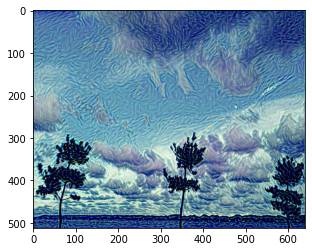

run [100]:
Style Loss : 61.318779 Content Loss: 57.130520



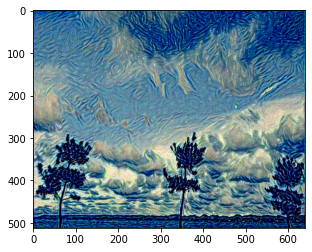

run [150]:
Style Loss : 279.669189 Content Loss: 69.546959



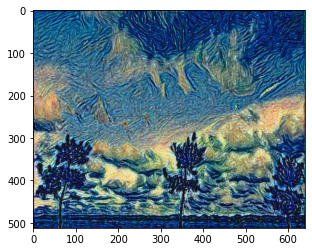

run [200]:
Style Loss : 16.606541 Content Loss: 57.183144



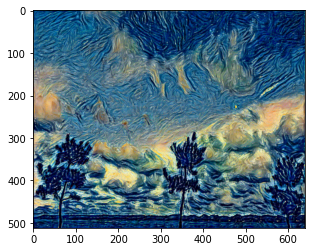

run [250]:
Style Loss : 25.491758 Content Loss: 50.888130



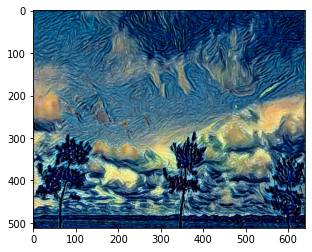

run [300]:
Style Loss : 12.573220 Content Loss: 49.248158



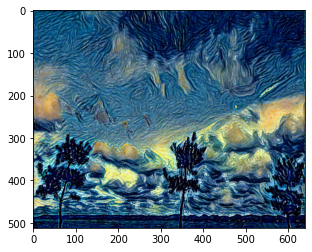

run [350]:
Style Loss : 40292560.000000 Content Loss: 1534.174194



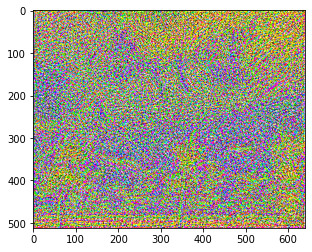

run [400]:
Style Loss : 21438.759766 Content Loss: 76.935669



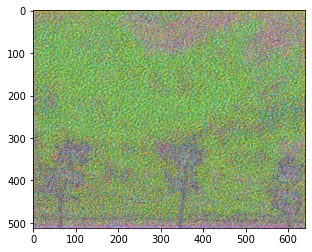

run [450]:
Style Loss : 297.005707 Content Loss: 71.803406



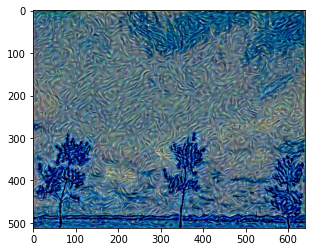

run [500]:
Style Loss : 72.320076 Content Loss: 72.255974



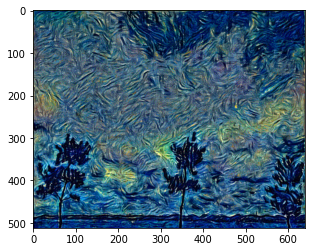

run [550]:
Style Loss : 28.886110 Content Loss: 64.844299



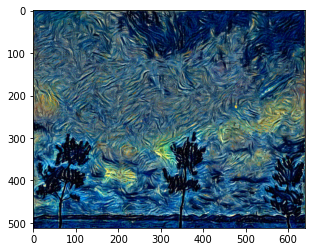

run [600]:
Style Loss : 20.933584 Content Loss: 56.715443



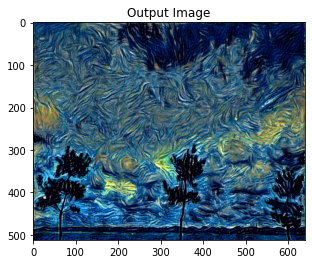

In [ ]:
#input_image, input_image_style, input_image_noise
#Change the input image here.
output = style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                        content_image, style_image, input_image,
                        num_steps=600).to(device)

plt.figure()
imshow(output, title='Output Image')

#plt.ion()
#plt.ioff() #Update the image last time.
#plt.show()

In [ ]:
save_image(output.cpu().detach()[0], 'output_1.png')
print('Complete')

Complete


In [ ]:
from google.colab import files
#files.download('output_1.png')